In [128]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy import stats

dl = DataLib("SignalData")

#### `TODO`
- Get bond premium
- Write out intuition for how this should perform
- Generate an indicator (z score)
- Generate a returns stream

In [129]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
lr = dl.pull('LongRates')
sr = dl.pull('ShortRates')

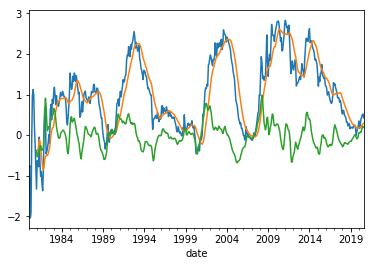

In [173]:
# Get bond premium. 
premium = lr - sr

# Take a 12-month rolling average. 
premium_sma = premium.rolling(12).mean()

# Also get a 12-3 rolling average. 
premium_sma_diff = premium.rolling(3).mean() - premium.rolling(12).mean()

# Plot the premium curve, the rolling average, and 18-6 difference.
premium['USA'].plot()
premium_sma['USA'].plot()
premium_sma_diff['USA'].plot()

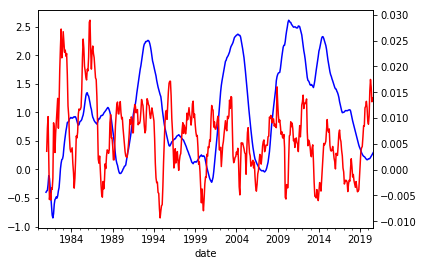

In [174]:
# Plot a rolling average of change in returns along with bond premium. 
bri_chg = bri.resample('M').mean().pct_change()
bri_chg_sma = bri_chg.rolling(12).mean()

fig, ax = plt.subplots()
bri_chg_sma['USA'].plot(ax=ax.twinx(), color='red')
# premium_sma_diff['USA'].plot(ax=ax.twinx(), color='green')
premium_sma['USA'].plot(ax=ax, color='blue')

In [175]:
# Get the rolling average and stdev for the past 12 months. 
sma = premium_sma_diff.rolling(12).mean()
std = premium_sma_diff.rolling(12).std()

# Turn the rolling premium into a zscore. 
zscore = (sma - premium_sma_diff) / std

zscore = zscore[zscore.index < '2020-08-01']

In [176]:
for country in bri.columns.values: 
    print(country)
    print('pearson corr:', zscore[country].corr(bri_chg_sma[country]))

AUS
pearson corr: 0.02124242975624505
DEU
pearson corr: -0.028326898421293416
CAN
pearson corr: -0.007189516194572128
ESP
pearson corr: -0.019152980563112154
FRA
pearson corr: 0.030664232059941367
ITA
pearson corr: 0.11532394904527553
JPN
pearson corr: 0.03518178754183409
CHE
pearson corr: 0.12245731252867571
GBR
pearson corr: -0.04863219937110378
USA
pearson corr: -0.029960216175138447


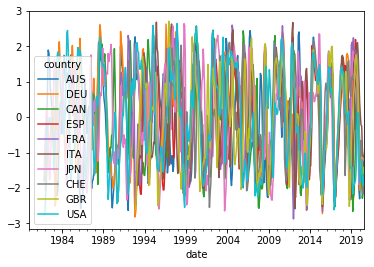

In [177]:
zscore.plot()

# Return stream

In [171]:
signal = (1 * zscore).clip(upper=2, lower=-2) / 2
signal = signal.dropna()

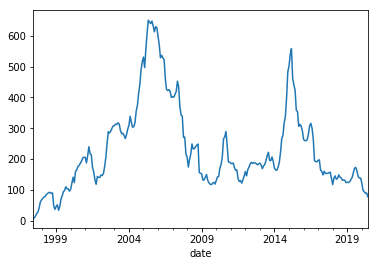

In [172]:
returns = bri.resample('M').mean().pct_change().loc[signal.index].shift(-1)
returns = (signal * returns).dropna().sum(axis=1)
cumul_returns = ((returns + 1).cumprod() - 1) * 100
cumul_returns.plot()